In [1]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

    print("Random seed initialized.")

set_global_determinism(seed=SEED)

Random seed initialized.


In [2]:
import pandas as pd
import json, cv2, re, math, ast
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAvgPool2D, Input, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger, TensorBoard, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import *
from tensorflow.keras.mixed_precision import Policy, set_global_policy, LossScaleOptimizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
import tensorflow_addons as tfa

import albumentations as A
from functools import partial
from imblearn.under_sampling import *
from imblearn.over_sampling import *

# Filter all Tensorflow logs except FATAL errors
tf.get_logger().setLevel('FATAL') #DEBUG,ERROR,FATAL,INFO,WARN

# Mixed Precision
set_global_policy(Policy('mixed_float16'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Mirrored Strategy
strategy = tf.distribute.MirroredStrategy(
    devices=["/gpu:0", "/gpu:1"], 
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
)

# Initialize paths
AUTOTUNE = tf.data.experimental.AUTOTUNE
PATH = 'D:\Datasets\plant-pathology'
ns_weights = 'D:\Datasets/noisy_student/noisy_student_efficientnet_b4.h5'

for x in device_lib.list_local_devices():
    if x.device_type == 'GPU':
        print(x.physical_device_desc)

device: 0, name: GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6
device: 1, name: GeForce RTX 3060, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [3]:
# Initialize variables
REPLICAS = strategy.num_replicas_in_sync
BATCH_SIZE_PER_REPLICA = 8
BUFFER_SIZE = 512
IMAGE_SIZE = [456, 456]
CLASSES = 6
n_train_augments = 1
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * REPLICAS
print('Number of replicas:', REPLICAS)
print('Global batch size:', GLOBAL_BATCH_SIZE)

Number of replicas: 2
Global batch size: 16


In [4]:
train = pd.read_csv(r'D:\Datasets\plant-pathology\train.csv')
IMG_PATH = r'D:\Datasets\plant-pathology\train_images'
train

,image_id,labels
0,Train_2.jpg,healthy
1,Train_4.jpg,healthy
2,Train_5.jpg,healthy
3,Train_9.jpg,healthy
4,Train_13.jpg,healthy
...,...,...
20357,fffb900a92289a33.jpg,healthy
20358,fffc488fa4c0e80c.jpg,scab
20359,fffc94e092a59086.jpg,rust
20360,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


# Duplicate Detection

Duplicates causes models to overfit as it introduces biases into our model during training. For example, if by chance a single batch contains duplicated images, the model will learn of this misleading pattern and will cause the accuracy scores to be exceptionally high. 

This will ultimately lead to large generalization errors during testing. Therefore, duplicated images or samples must be removed beforehand.

## Image hashing

In [5]:
# funcs = [
#         imagehash.average_hash,
#         imagehash.phash,
#         imagehash.dhash,
#         imagehash.whash,
#     ]
# image_ids = []
# hashes = []

# for path in tqdm(train['image_id'], desc='Hashing images'):
#     image = Image.open(os.path.join(IMG_PATH, path))
#     image_id = os.path.basename(path)
#     image_ids.append(image_id)
#     hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

# hashes_all = np.array(hashes)
# hashes_all = torch.Tensor(hashes_all.astype(int))
# sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).numpy()/256 for i in tqdm(range(hashes_all.shape[0]), desc='Calculating similarities')])

# indices1 = np.where(sims > 0.9)
# indices2 = np.where(indices1[0] != indices1[1])
# image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
# image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
# dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}
# duplicate_image_ids = sorted(list(dups))
# print('Found %d duplicates' % len(duplicate_image_ids))

# # Remove duplicates from external data
# imgs_to_remove = [x[1] for x in duplicate_image_ids]

# duplicates = pd.DataFrame(duplicate_image_ids)
# duplicates.columns = ['image0', 'image1']

duplicates = pd.read_csv('D:\Datasets\plant-pathology\duplicates.csv')
duplicates

,image0,image1
0,800f85dc5f407aef.jpg,Train_64.jpg
1,803f899768b5b789.jpg,Train_394.jpg
2,807947b90eb77856.jpg,Train_1256.jpg
3,808c7cabba2f9572.jpg,Train_1560.jpg
4,809c3fc2796fd84a.jpg,Train_45.jpg
...,...,...
706,e8a58ad4d9829f33.jpg,e8bd8ac4d982dd83.jpg
707,e90e1ac8b7e7aa50.jpg,e90e1acab7e5aa50.jpg
708,ebd19f1c549a1ad0.jpg,ebd19f9c549a12d0.jpg
709,f0cb859beb1b30c1.jpg,f0cb879e4a1b35c1.jpg


In [6]:
# nrows = 5; ncols=2
# fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
# for i, row in enumerate(duplicates.to_numpy()[-nrows:]):
#     image0 = cv2.imread(os.path.join(IMG_PATH, row[0]))
#     axes[i][0].axis('off')
#     axes[i][0].set_title(row[0])
#     axes[i][0].imshow(image0)

#     image1 = cv2.imread(os.path.join(IMG_PATH, row[1]))
#     axes[i][1].axis('off')
#     axes[i][1].set_title(row[1])
#     axes[i][1].imshow(image1)

# plt.tight_layout()
# plt.show()

In [7]:
train[train['image_id'].isin(duplicates['image1'].tolist())]['labels'].value_counts()

rust                       629
rust frog_eye_leaf_spot     16
healthy                     14
scab                        11
complex                     10
rust complex                 2
frog_eye_leaf_spot           1
Name: labels, dtype: int64

In [8]:
train = train[~train['image_id'].isin(duplicates['image1'].tolist())].reset_index(drop=True)
print("train shape after duplicates removed:", train.shape)

train shape after duplicates removed: (19679, 2)


# Reshape

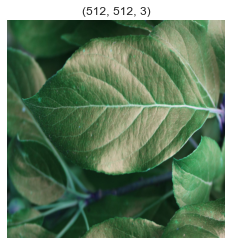

In [9]:
def image_resize(x):
    image = cv2.imread(os.path.join(IMG_PATH, x))
    if image.shape[0] > image.shape[1]:
        image = cv2.transpose(image)
    else:
        image = image   
    return cv2.resize(image, dsize=(512, 512))

image = image_resize(train['image_id'][10])
plt.axis('off')
plt.imshow(image)
plt.title(image.shape)
plt.show()

# Redistributing classes

We redistribute the combination classes to reduce the imbalance of the dataset. i.e scab

In [10]:
train['labels'].value_counts()

scab                               5407
healthy                            5126
frog_eye_leaf_spot                 3180
rust                               1853
complex                            1592
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             104
rust complex                         95
powdery_mildew complex               87
Name: labels, dtype: int64

In [11]:
# class_map = {
#     "scab": "scab",
#     "healthy": "healthy",
#     "frog_eye_leaf_spot": "frog_eye_leaf_spot",
#     "rust": "rust",
#     "complex": "complex",
#     "powdery_mildew": "powdery_mildew",
#     "scab frog_eye_leaf_spot": "frog_eye_leaf_spot",
#     "scab frog_eye_leaf_spot complex": "frog_eye_leaf_spot",
#     "frog_eye_leaf_spot complex": "frog_eye_leaf_spot",
#     "rust frog_eye_leaf_spot": "rust",
#     "rust complex": "rust",
#     "powdery_mildew complex": "powdery_mildew"
# }

# train['labels'] = train['labels'].map(class_map)
# train['labels'].value_counts()

In [12]:
train = train[train['labels'].isin(train['labels'].value_counts()[train['labels'].value_counts()>=1000].index)].reset_index(drop=True)
train

,image_id,labels
0,Train_2.jpg,healthy
1,Train_4.jpg,healthy
2,Train_5.jpg,healthy
3,Train_9.jpg,healthy
4,Train_13.jpg,healthy
...,...,...
18337,fffaa4a0fe416808.jpg,scab
18338,fffb65761200b054.jpg,healthy
18339,fffb900a92289a33.jpg,healthy
18340,fffc488fa4c0e80c.jpg,scab


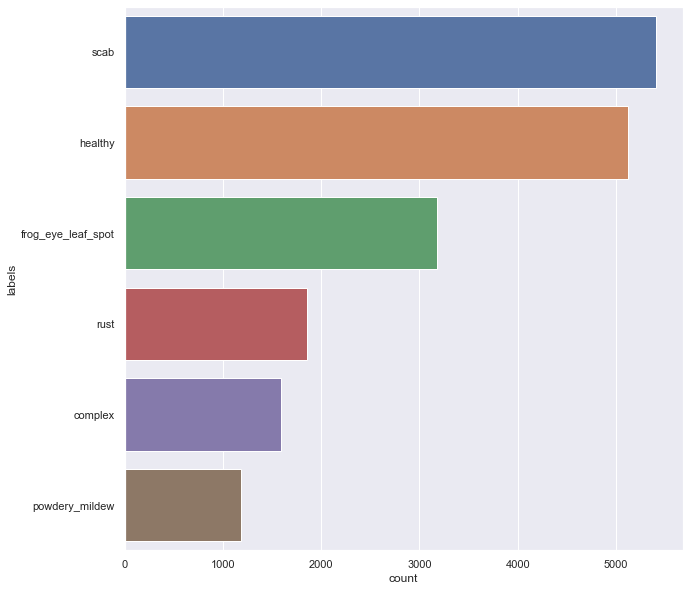

In [13]:
plt.figure(figsize=(10,10))
sns.countplot(y=train['labels'], order=train['labels'].value_counts().index)
plt.show()

In [14]:
# Label encode
train['labels_codes'] = pd.Categorical(train['labels']).codes
train = train.drop('labels', axis=1)
train

,image_id,labels_codes
0,Train_2.jpg,2
1,Train_4.jpg,2
2,Train_5.jpg,2
3,Train_9.jpg,2
4,Train_13.jpg,2
...,...,...
18337,fffaa4a0fe416808.jpg,5
18338,fffb65761200b054.jpg,2
18339,fffb900a92289a33.jpg,2
18340,fffc488fa4c0e80c.jpg,5


In [15]:
def class_weight(j_samples):
    n_classes = len(j_samples)
    total_samples = j_samples.sum()
    class_weight = dict(total_samples/(n_classes*j_samples))
    return class_weight
    
class_weight = class_weight(j_samples=train['labels_codes'].value_counts())
class_weight

{5: 0.565378213427039,
 2: 0.5963714397190792,
 1: 0.9613207547169811,
 4: 1.6497571505666486,
 0: 1.9202261306532664,
 3: 2.581925675675676}

# Convert images to TFREC shards

In [16]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_example(feature0, feature1, feature2):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'image': _bytes_feature(feature0),
      'target': _int64_feature(feature1),
      'image_name': _bytes_feature(feature2),
  }

  # Create a Features message using tf.train.Example.
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

def image_resize(x):
    image = cv2.imread(os.path.join(IMG_PATH, x))
    if image.shape[0] > image.shape[1]:
        image = cv2.transpose(image)
    else:
        image = image   
    return cv2.resize(image, dsize=IMAGE_SIZE)

#### Train set

In [17]:
# Obtain the multiple of training set size for even splitting
fold_list = []
print('Possible number of folds:')
for n in range(1,30):
    if np.divmod(train.shape[0], n)[1]==0:
        print('{} folds - {} images per fold'.format(n, int(train.shape[0]/n)))
        fold_list.append(n)

Possible number of folds:
1 folds - 18342 images per fold
2 folds - 9171 images per fold
3 folds - 6114 images per fold
6 folds - 3057 images per fold
9 folds - 2038 images per fold
18 folds - 1019 images per fold


In [18]:
# N_FILES = 18
# IMG_QUALITY = 100
# IMAGE_SIZE = (512, 512)
# train['shard'] = 0

# # Stratify the shards
# skf = StratifiedKFold(n_splits=N_FILES, shuffle=True, random_state=42)
# for fold, (train_idx, val_idx) in enumerate(skf.split(train, train['labels_codes'])):
#     train.loc[val_idx, 'shard'] = fold

# # Rewrite the TFRecords after stratification and resize
# for tfrec_num in tqdm(range(N_FILES), desc='Writing TFRecords'):
#     samples = train[train['shard'] == tfrec_num]
#     n_samples = len(samples)
#     with tf.io.TFRecordWriter('train-%.2i-%i.tfrec'%(tfrec_num, n_samples)) as writer:
#         for row in tqdm(samples.itertuples(), desc=('Fold {}'.format(tfrec_num+1)), total=int(train.shape[0]/N_FILES)):
#             label = row.labels_codes
#             image_name = row.image_id
#             img = image_resize(image_name)
#             img = cv2.imencode('.jpg', img, (cv2.IMWRITE_JPEG_QUALITY, IMG_QUALITY))[1].tobytes()
#             example = serialize_example(img, label, str.encode(image_name))
#             writer.write(example)

# Loading tfrec shards

In [19]:
# FILENAMES = tf.io.gfile.glob(PATH + "/train_images_512x512_base_18fold/*.tfrec") # Removed
FILENAMES = tf.io.gfile.glob(PATH + "/train_images_512x512_base_6class/*.tfrec") # Redistributed
FILENAMES

['D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-00-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-01-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-02-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-03-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-04-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-05-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-06-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-07-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-08-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-09-1019.tfrec',
 'D:\\Datasets\\plant-pathology\\train_images_512x512_base_18fold\\train-10-1019.tfrec',
 'D:\\Datasets\\plant

In [20]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)/255.0
    image = tf.image.resize(image, size=IMAGE_SIZE, method='nearest')
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    labeled_map = {"image": tf.io.FixedLenFeature([], tf.string),
                    "target": tf.io.FixedLenFeature([], tf.int64)}
    unlabeled_map = {"image": tf.io.FixedLenFeature([], tf.string)}

    tfrecord_format = (labeled_map if labeled else unlabeled_map)
    
    example = tf.io.parse_single_example(serialized=example,
                                  features=tfrecord_format)

    image = decode_image(example["image"])

    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled),
        num_parallel_calls=AUTOTUNE
        )
    return dataset

def one_hot(image, label):
    return image, tf.one_hot(indices=label, 
                             depth=CLASSES,
                             dtype=tf.float32)

def count_data_items(filenames):
    """Obtaining total number of images in dataset from
    the tfrecord shards."""
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1))
         for filename in filenames]
    return np.sum(n)

# Augmentation

The purpose of augmentation is to synthetically create copies of our image data due to the lack of images. This can be done by rotation, cropping, blurring and many more. By doing this, our model will be able to learn more on the same number of samples.

For our major classes, no augmentation should be required as we do not want to create more copies for these classes, therefore we will leave them as raw images to keep their information intact.

## Training set

In [21]:
def album_augment(image, label):
    transforms = A.Compose([
        A.RandomResizedCrop(*IMAGE_SIZE),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=0, p=0.5),
        A.Cutout(num_holes=1, max_h_size=round(IMAGE_SIZE[0]*0.1), max_w_size=round(IMAGE_SIZE[0]*0.1))
    ])

    # Raw images are taken and the rest are augmented
    images = [image]
    labels = [label]

    for _ in range(n_train_augments):
        aug_image = transforms(image=image)['image']
        aug_image = tf.cast(x=aug_image, dtype=tf.float32)
        images.append(aug_image)
        labels.append(label)
    
    return images, labels
    
def train_augment(image, label):
    aug_func = tf.numpy_function(func=album_augment, inp=[image, label], Tout=[tf.float32, tf.int32])
    return aug_func

In [22]:
@tf.function
def cutmix(image, label, PROBABILITY=0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]

    imgs = []; labs = []
    for j in range(GLOBAL_BATCH_SIZE):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,GLOBAL_BATCH_SIZE), tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        lab1 = label[j,]
        lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    image2 = tf.reshape(tf.stack(imgs),(GLOBAL_BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(GLOBAL_BATCH_SIZE,CLASSES))
    return image2, label2

In [23]:
def get_train_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.map(partial(train_augment), num_parallel_calls=AUTOTUNE)
    dataset = dataset.unbatch() # Uncomment if oversampling
    dataset = dataset.shuffle(BUFFER_SIZE*n_train_augments)
    dataset = dataset.repeat()
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.map(cutmix, num_parallel_calls=AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) # Turn off prefetch if using image size larger than 512
    return dataset

In [24]:
def augm_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.map(partial(train_augment), num_parallel_calls=AUTOTUNE)
    # dataset = dataset.batch(BATCH_SIZE_PER_REPLICA) # Uncomment if oversampling
    return dataset

## Validation set

In [25]:
"""repeat() required to increase validation_steps"""
def get_val_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.map(one_hot, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## Augment Visualization

In [28]:
def display_train_image(dataset):
    dataset = dataset.unbatch().batch(16)
    images, labels = next(iter(dataset))
    col = 4; row = 4
    plt.figure(figsize=(10, 10))
    for i in range(row*col):
        plt.subplot(row, col, i+1)
        plt.axis('off')
        image = tf.image.convert_image_dtype(images[i], 'uint8')
        plt.imshow(image)

    plt.tight_layout()
    plt.show()

### Raw images

In [29]:
# display_train_image(get_val_dataset(FILENAMES))

### Albumentations Augmentation

In [30]:
# display_train_image(augm_dataset(FILENAMES))

### Final Augmentation

In [31]:
# display_train_image(get_train_dataset(FILENAMES))

# Model training

### Wrapper Functions

In [32]:
"""Set from_logits=False when using Dense Softmax output layer"""
def create_model(model, learning_rate, dropout_rate, 
label_smoothing, weights):
    with strategy.scope():
        inputs = Input(shape=(*IMAGE_SIZE, 3)) 
        base_model = model(
                include_top=False, 
                weights=weights,
                pooling='avg'
            )(inputs)

        hidden = Dropout(dropout_rate)(base_model)
        outputs = Dense(CLASSES, activation='softmax', dtype='float32')(hidden)
        model = Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=LossScaleOptimizer(
                Adam(learning_rate=learning_rate)),
            loss=CategoricalCrossentropy(
                from_logits=False, 
                label_smoothing=label_smoothing),
            metrics=[
                'categorical_accuracy',
                tfa.metrics.F1Score(
                    num_classes=CLASSES,
                    average='macro',
                    name='f1_score'
                )]
            )
        return model

def model_training(model, model_name, weights, learning_rate, 
  dropout_rate, decay_rate, decay_steps, label_smoothing, fold, n_splits, epochs):
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    lr_schedule = LearningRateScheduler(ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True), verbose=1)

    early_stopping = EarlyStopping(
        monitor='val_f1_score',
        patience=10,
        verbose=1,
        mode='max',
        restore_best_weights=False
    )

    for i, (train_idx, valid_idx) in enumerate(cv.split(FILENAMES)): 
        if i == (fold-1):
            model_name = model_name
            filepath = model_name + '-fold' + str(i+1) + '-epoch{epoch:02d}-f1_{f1_score:.4f}-valf1_{val_f1_score:.4f}.h5'
            model_save = ModelCheckpoint(
                filepath=filepath,
                save_best_only=False,
                save_freq='epoch',
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                verbose=1)

            filename = model_name + '-fold' + str(i+1) + '.csv'
            csv_logger = CSVLogger(
                filename=filename, 
                separator=',', 
                append=False)

            TRAIN_FILENAMES = [FILENAMES[id] for id in train_idx]
            VALID_FILENAMES = [FILENAMES[id] for id in valid_idx]
            
            N_TRAIN_IMAGES = count_data_items(TRAIN_FILENAMES)
            N_VALID_IMAGES = count_data_items(VALID_FILENAMES)

            print('Number of training images:', N_TRAIN_IMAGES)
            print('Number of validation images:', N_VALID_IMAGES)

            print(f'\n-------------- FOLD {i+1}/{n_splits} --------------')

            train = get_train_dataset(TRAIN_FILENAMES)
            val = get_val_dataset(VALID_FILENAMES)

            model = create_model(
                model=model,
                weights=weights,
                dropout_rate=dropout_rate,
                learning_rate=learning_rate,
                label_smoothing=label_smoothing
            )
            
            history = model.fit(
                x=train,
                verbose=1,
                epochs=epochs,
                validation_data=val,
                batch_size=GLOBAL_BATCH_SIZE,
                steps_per_epoch=(N_TRAIN_IMAGES//GLOBAL_BATCH_SIZE),
                validation_steps=(N_VALID_IMAGES//GLOBAL_BATCH_SIZE),
                shuffle=True,
                class_weight=class_weight,
                callbacks=[
                    lr_schedule,
                    early_stopping,
                    model_save,
                    csv_logger]
                )

### Learning Schedule

0 tf.Tensor(1e-04, shape=(), dtype=float32)
19 tf.Tensor(1.953125e-07, shape=(), dtype=float32)


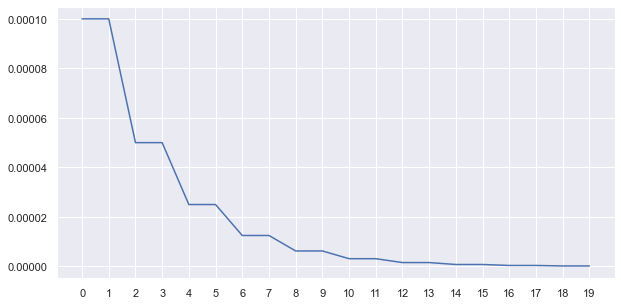

In [33]:
decay_rate = 0.5
learning_rate = 1e-4
decay_steps = 2
epochs = 20

lr_schedule = ExponentialDecay(
    learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True)

y = [lr_schedule(x) for x in range(epochs)]

for epoch, lr in enumerate(y):
  if epoch==0 or epoch==(len(y)-1):
    print(epoch, lr)

plt.figure(figsize=(10,5))
plt.plot(range(epochs), y)
plt.xticks(range(epochs))
plt.show()

### EfficientNet

In [34]:
# model_training(
#         model=EfficientNetB5,
#         model_name='output/model3_EFNB5',
#         weights='imagenet',
#         learning_rate=learning_rate,
#         decay_rate=decay_rate,
#         decay_steps=decay_steps,
#         dropout_rate=0,
#         label_smoothing=0.1,
#         n_splits=5,
#         fold=1,
#         epochs=epochs)

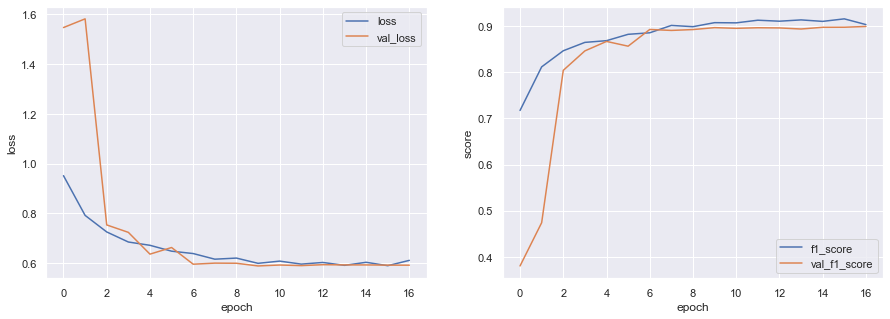

In [79]:
filename = r'C:\Users\xBaka\Notebooks\Plant_patho\output\model2_EFNB5-fold1.csv'
history = pd.read_csv(filename)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.lineplot(x='epoch', y='loss', data=history, label='loss', ax=ax1)
sns.lineplot(x='epoch', y='val_loss', data=history, label='val_loss',ax=ax1)
sns.lineplot(x='epoch', y='f1_score', data=history, label='f1_score', ax=ax2)
sns.lineplot(x='epoch', y='val_f1_score', data=history, label='val_f1_score',ax=ax2)
plt.ylabel('score')
plt.show()

# Ensemble + Test-time Augmentation

In [55]:
def get_test_dataset(filenames, labeled=False):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [57]:
TEST_FILENAMES = tf.io.gfile.glob(PATH + "/test_images_tfrec_512x512/*.tfrec")
test_dataset = get_test_dataset(TEST_FILENAMES)
test_dataset

<PrefetchDataset shapes: (None, 456, 456, 3), types: tf.float32>

In [63]:
from tensorflow.keras.models import load_model

model_path = r'C:\Users\xBaka\Notebooks\Plant_patho\output\final_models'
models = tf.io.gfile.glob(model_path + '/*.h5')
model = load_model(models[0])
pred = model.predict(test_dataset)
pred

array([[0.02971839, 0.01228039, 0.0382354 , 0.01780946, 0.00961894,
        0.89233744],
       [0.11675651, 0.83603966, 0.01283315, 0.00794266, 0.01122244,
        0.01520559],
       [0.02115354, 0.8951318 , 0.01336776, 0.01955196, 0.0198742 ,
        0.03092069]], dtype=float32)

In [77]:
label_map = {
    0: 'complex',
    1: 'frog_eye_leaf_spot',
    2: 'healthy',
    3: 'powdery_mildew',
    4: 'rust',
    5: 'scab'
}

In [78]:
submission = pd.DataFrame({'image': os.listdir(r'D:\Datasets\plant-pathology\test_images'), 'labels': np.argmax(pred, axis=1)})
submission['labels'] = submission['labels'].map(label_map)
submission

,image,labels
0,85f8cb619c66b863.jpg,scab
1,ad8770db05586b59.jpg,frog_eye_leaf_spot
2,c7b03e718489f3ca.jpg,frog_eye_leaf_spot
